In [117]:
#Imports
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
import seaborn as sns

import torch           
import torch.nn as nn   
import torchvision     
from torch.utils.data import Dataset, DataLoader, random_split, Subset 
import torchvision.transforms as tt 

import torch.nn.functional as F 

from torchvision.utils import make_grid  
import matplotlib.pyplot as plt          
from matplotlib.image import imread     
import os
import random
from tqdm import tqdm 

In [118]:
def load_prep_data (data):
    #Drop NAs
    data = data.dropna()

    # Normalizing Data
    
    # Ordinal Encoding for 'HomeTeam' and 'AwayTeam' columns
    ordinal_encoder = OrdinalEncoder()
    data[['HomeTeam', 'AwayTeam']] = ordinal_encoder.fit_transform(data[['HomeTeam', 'AwayTeam']])

    # Encode 'FTR' column (Full Time Result)
    ftr_mapping = {'H': 0, 'A': 1, 'D': 2}
    data['outcome'] = data['FTR'].map(ftr_mapping)

    # Scale numeric columns
    scaler = MinMaxScaler()
    num_cols = ['B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA', 'HomeTeam', 'AwayTeam']
    data[num_cols] = scaler.fit_transform(data[num_cols])

    # Drop unnecessary columns
    data.drop(['Date', 'FTR'], axis=1, inplace=True)

    # Separate the features and the target variable
    X = data.drop(columns=['outcome'])
    y = data['outcome']

    # Create polynomial features (excluding 'HomeTeam' and 'AwayTeam')
    poly_cols = ['B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA']
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    X_poly = poly.fit_transform(X[poly_cols])

    # Create a dataframe with the new polynomial features
    poly_feature_names = poly.get_feature_names_out(input_features=poly_cols)
    poly_features = pd.DataFrame(X_poly, columns=poly_feature_names)

    # Concatenate the polynomial features with the original features
    data = pd.concat([X[['HomeTeam', 'AwayTeam']], poly_features, y], axis=1)

    # Drop rows with NaN values
    data = data.dropna()

    data.to_csv('data.csv', index=False)

    return data


In [134]:
#Load and Modify Data
data_orig = pd.read_csv("final_data_GER_ENG_ESP.csv")

#load and prep the data
data = load_prep_data(data_orig)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['outcome']), data['outcome'], test_size=0.2, random_state=42, stratify=data['outcome'])

print(y_train.value_counts())
print(y_test.value_counts())

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Update the input_size variable
input_size = X_train.shape[1]
print("input size:", input_size)
output_size = len(np.unique(y))
print("output size:", output_size)


/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_34219/3953700863.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['HomeTeam', 'AwayTeam']] = ordinal_encoder.fit_transform(data[['HomeTeam', 'AwayTeam']])
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_34219/3953700863.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outcome'] = data['FTR'].map(ftr_mapping)
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_34219/3953700863.py:18: SettingWithCopyWarning: 
A val

outcome
0.0    8371
1.0    5264
2.0    4501
Name: count, dtype: int64
outcome
0.0    2093
1.0    1316
2.0    1125
Name: count, dtype: int64
X_train shape: (18136, 29)
X_test shape: (4534, 29)
input size: 29
output size: 3


In [135]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class MyCNNWithAttention(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyCNNWithAttention, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.attn1 = ChannelAttention(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.attn2 = ChannelAttention(32)
        self.flatten = nn.Flatten()

        # Calculate the output size of the previous layers
        conv1_output_size = (input_size + 2 * 1 - 3) // 1 + 1
        pool1_output_size = (conv1_output_size - 2) // 2 + 1
        conv2_output_size = (pool1_output_size + 2 * 1 - 3) // 1 + 1
        pool2_output_size = (conv2_output_size - 2) // 2 + 1
        fc1_input_size = 32 * pool2_output_size

        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 1, self.input_size)  # Reshape the input to (batch_size, 1, input_size)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.attn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.attn2(x)
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [136]:
# Create an instance of SMOTEENN or SMOTETomek
#combiner = SMOTEENN(random_state=42) 

# Perform combined oversampling and undersampling on the training data
#X_train_resampled, y_train_resampled = combiner.fit_resample(X_train, y_train)

# Print the shape of the resampled training data
#print("X_train_resampled shape:", X_train_resampled.shape)
#print("y_train_resampled shape:", y_train_resampled.shape)

# Convert the resampled data to tensors
#X_train_tensor = torch.tensor(X_train_resampled.values).float()
#y_train_tensor = torch.tensor(y_train_resampled.values).long()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).long()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).long()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = MyCNNWithAttention(input_size, output_size)


In [137]:
def training(model, loss_function, optimizer, train_loader, n_epochs, update_interval):
    losses = []
    for n in range(n_epochs):
        epoch_losses = []
        for i, (images, labels) in enumerate(tqdm(iter(train_loader))):
            optimizer.zero_grad()
            my_output = model(images)
            loss = loss_function(my_output, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
            if i % update_interval == 0:
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                losses.append(round(avg_loss, 2))
                epoch_losses = []
                
    avg_total_loss = sum(losses) / len(losses)
    print("Training losses:", losses)
    print(f"Average loss over entire training: {avg_total_loss:.2f}")
    
    return model, losses

100%|██████████| 284/284 [00:01<00:00, 209.79it/s]


Training losses: [1.15, 1.15, 1.12, 1.15, 1.11, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.08, 1.1, 1.1, 1.09, 1.1, 1.1, 1.11, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.12, 1.1, 1.1, 1.08, 1.09, 1.1, 1.1, 1.1, 1.09, 1.12, 1.1, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.06, 1.09, 1.09, 1.11, 1.09, 1.09, 1.12, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.13, 1.09, 1.09, 1.11, 1.09, 1.09, 1.11, 1.09, 1.09, 1.11, 1.09, 1.09, 1.07, 1.09, 1.09, 1.13, 1.09, 1.09, 1.08, 1.09, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.09, 1.06, 1.09, 1.09, 1.07, 1.09, 1.09, 1.11, 1.09, 1.09, 1.08, 1.09, 1.09, 1.06, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.09, 1.09, 1.08, 1.09, 1.09, 1.07, 1.09, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.07, 1.09, 1.09, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.12, 1.0

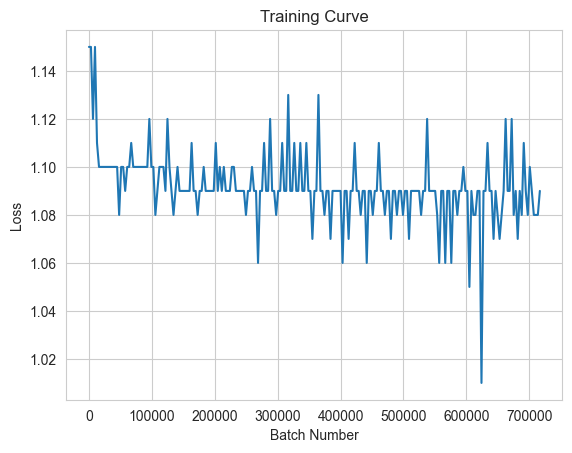

In [138]:
# Model Training
lr = 0.001
batch_size = 32
update_interval = 100
n_epochs = 75

class_counts = y_train.value_counts().sort_index()
weights = 1. / class_counts
class_weights = torch.tensor(weights.values).float()

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_loader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("Training Curve")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.show()

In [139]:
def testing(model, loss_function, test_loader):
    model.eval()
    sum_loss = 0
    n_correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for i, (data, label) in enumerate(tqdm(iter(test_loader))):
            
            pred = model(data)
            loss = loss_function(pred, label)
            sum_loss += loss.item()
            
            _, predicted = torch.max(pred, 1)
            n_correct += (predicted == label).sum().item()
            total += label.size(0)
            
            true_labels.extend(label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    test_acc = round((n_correct / total) * 100, 2)
    avg_loss = round(sum_loss / len(test_loader), 2)
    
    return test_acc, avg_loss, true_labels, predicted_labels

In [140]:
# Model Testing
test_acc, avg_loss, true_labels, predicted_labels = testing(trained_model, loss_function, test_loader)
print("Testing accuracy of your trained model:", test_acc)
print("Average loss of your trained model:", avg_loss)

100%|██████████| 71/71 [00:00<00:00, 479.21it/s]

Testing accuracy of your trained model: 42.9
Average loss of your trained model: 1.09


[[1368  659   66]
 [ 723  540   53]
 [ 685  403   37]]


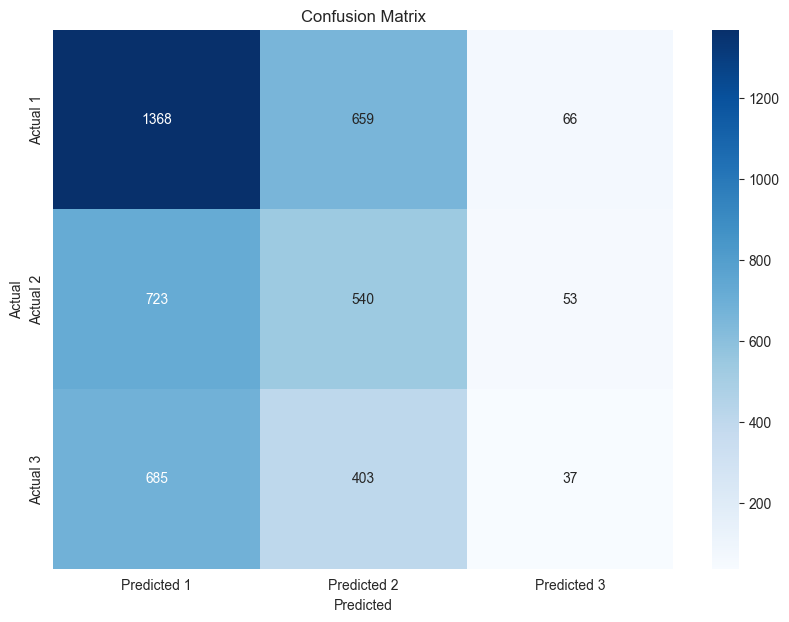

In [141]:
#Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'], yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [142]:
def K_fold(model_class, model_params, dataset, K=5):
    #hyperparams_grid = {
    #    'batch_size': [24, 32, 64, 128, 256],
    #   'lr': [0.001, 0.01, 0.1, 0.5],
    #   'n_epochs': [20, 30, 50, 75, 100],
    #    'update_interval': [25, 50, 100, 200, 250]
    #}
    hyperparams_grid = {'batch_size': [32], 'lr': [0.001], 'n_epochs': [75], 'update_interval': [100]}

    
    best_model = None
    best_accuracy = -1
    best_losses = []
    best_hyperparams = {}
    
    
    total_combinations = len(hyperparams_grid['batch_size']) * len(hyperparams_grid['lr']) * len(hyperparams_grid['n_epochs']) * len(hyperparams_grid['update_interval'])
    print("Total combinations: ", total_combinations)
    
    kfold = KFold(n_splits=K, shuffle=True, random_state=42)
    
    for batch_size, lr, n_epochs, update_interval in tqdm([(bs, lr, ep, ui) for bs in hyperparams_grid['batch_size'] for lr in hyperparams_grid['lr'] for ep in hyperparams_grid['n_epochs'] for ui in hyperparams_grid['update_interval']], total=total_combinations, desc='Hyperparameter Combinations', disable=False):
        print(f"Testing combination: Batch Size={batch_size}, LR={lr}, Epochs={n_epochs}, Update Interval={update_interval}")
        
        avg_accuracy = 0
        avg_loss = 0
        skip_combination = False
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{K}")
            
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
            
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
            
            model = model_class(*model_params)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_function = nn.CrossEntropyLoss()
            
            # Train model using the provided training method
            trained_model, training_losses = training(model, loss_function, optimizer, train_loader, n_epochs, update_interval)
            
            # Validate model using the provided testing method
            val_accuracy, val_loss, _, _ = testing(trained_model, loss_function, val_loader)
            
            # Check if the validation accuracy is below 50%
            if val_accuracy < 47:
                skip_combination = True
                print(f"Accuracy: {val_accuracy}")
                break
            
            avg_accuracy += val_accuracy
            avg_loss += val_loss
        
        if skip_combination:
            print("Skipping combination due to low accuracy")
            continue
        
        avg_accuracy /= K
        avg_loss /= K
        
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_model = model
            best_losses.append(avg_loss)
            best_hyperparams = {'batch_size': batch_size, 'lr': lr, 'n_epochs': n_epochs, 'update_interval': update_interval}
            print(f"Average accuracy across folds: {avg_accuracy}%, Average loss: {avg_loss}")
    
    return best_model, best_losses, best_hyperparams

best_model, best_losses, best_hyperparams = K_fold(MyCNNWithAttention, (input_size, output_size), train_dataset)


Total combinations:  1


Hyperparameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Testing combination: Batch Size=32, LR=0.001, Epochs=75, Update Interval=100
Fold 1/5


100%|██████████| 454/454 [00:01<00:00, 245.04it/s]


Training losses: [1.18, 1.12, 1.09, 1.09, 1.07, 1.04, 1.07, 1.06, 1.07, 1.07, 1.07, 1.06, 1.07, 1.07, 1.07, 1.02, 1.07, 1.06, 1.06, 1.06, 1.06, 1.06, 1.07, 1.07, 1.06, 1.0, 1.07, 1.06, 1.06, 1.06, 1.11, 1.06, 1.06, 1.07, 1.06, 0.97, 1.05, 1.06, 1.07, 1.07, 1.05, 1.06, 1.05, 1.07, 1.07, 1.13, 1.06, 1.06, 1.07, 1.06, 1.07, 1.06, 1.06, 1.07, 1.06, 1.03, 1.07, 1.06, 1.05, 1.06, 1.08, 1.06, 1.05, 1.06, 1.07, 1.02, 1.06, 1.05, 1.07, 1.06, 1.1, 1.06, 1.06, 1.06, 1.07, 1.02, 1.06, 1.06, 1.05, 1.06, 0.99, 1.07, 1.06, 1.06, 1.06, 1.04, 1.06, 1.07, 1.06, 1.05, 1.11, 1.05, 1.06, 1.06, 1.06, 1.01, 1.06, 1.06, 1.06, 1.06, 1.07, 1.06, 1.05, 1.06, 1.06, 1.05, 1.06, 1.06, 1.06, 1.05, 1.08, 1.05, 1.06, 1.06, 1.06, 1.04, 1.06, 1.06, 1.06, 1.06, 1.07, 1.05, 1.07, 1.06, 1.06, 1.12, 1.06, 1.05, 1.06, 1.06, 1.15, 1.06, 1.06, 1.05, 1.06, 1.13, 1.06, 1.06, 1.05, 1.06, 1.07, 1.06, 1.05, 1.06, 1.06, 1.13, 1.05, 1.05, 1.06, 1.05, 0.96, 1.06, 1.06, 1.06, 1.05, 1.1, 1.05, 1.05, 1.06, 1.06, 1.02, 1.05, 1.05, 1.06, 1

Hyperparameter Combinations: 100%|██████████| 1/1 [02:22<00:00, 142.37s/it]

Accuracy: 46.64
Skipping combination due to low accuracy


Best Hyperparameters:
{}


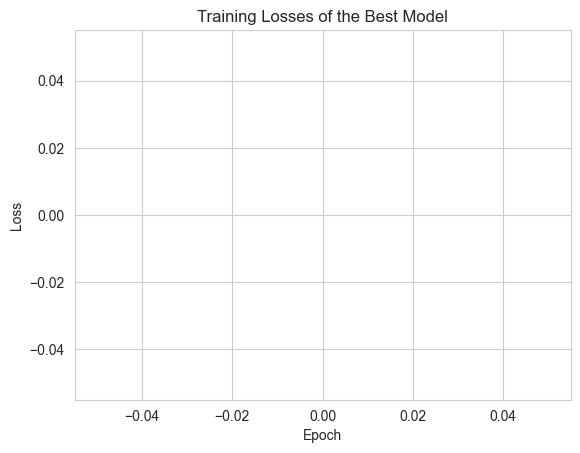

AttributeError: 'NoneType' object has no attribute 'eval'

In [143]:
print("Best Hyperparameters:")
print(best_hyperparams)

plt.plot(best_losses)
plt.title("Training Losses of the Best Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

test_acc, test_loss, true_labels, predicted_labels = testing(best_model, loss_function, test_loader)
print("Test Accuracy: {:.2f}%".format(test_acc))
print("Test Loss: {:.4f}".format(test_loss))

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [82]:
def process_data(data):
    # Drop NAs
    data = data.dropna()

    # Ordinal Encoding for 'HomeTeam' and 'AwayTeam' columns
    ordinal_encoder = OrdinalEncoder()
    data[['HomeTeam', 'AwayTeam']] = ordinal_encoder.fit_transform(data[['HomeTeam', 'AwayTeam']])

    # Scale numeric columns
    scaler = MinMaxScaler()
    num_cols = ['B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA', 'HomeTeam', 'AwayTeam']
    data[num_cols] = scaler.fit_transform(data[num_cols])

    # Drop the 'Date' column if it's not needed for prediction
    data.drop(['Date'], axis=1, inplace=True)

    # Create polynomial features
    poly_cols = ['B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA']
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    X_poly = poly.fit_transform(data[poly_cols])

    # Create a dataframe with the new polynomial features
    poly_feature_names = poly.get_feature_names_out(input_features=poly_cols)
    poly_features = pd.DataFrame(X_poly, columns=poly_feature_names)

    # Concatenate the polynomial features with the original features
    # excluding 'HomeTeam' and 'AwayTeam' if they were part of poly_cols
    data.reset_index(drop=True, inplace=True)
    poly_features.reset_index(drop=True, inplace=True)
    data = pd.concat([data[['HomeTeam', 'AwayTeam']], poly_features], axis=1)

    return data


In [83]:
def predict(data, model):
    # Preprocess the data
    data_processed = process_data(data)
    
    # Ensure the number of features matches model's input_size
    assert data_processed.shape[1] == model.input_size, f"Model expected {model.input_size} features, but got {data_processed.shape[1]}"
    
    # Convert to PyTorch tensor
    X_new = torch.tensor(data_processed.values).float()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(X_new)
    
    # Convert the predictions to labels
    _, predicted_labels = torch.max(predictions, 1)
    
    # Map the numeric labels back to string labels
    label_mapping = {0: 'H', 1: 'A', 2: 'D'}
    predicted_labels = [label_mapping[label.item()] for label in predicted_labels]
    
    return predicted_labels

In [106]:
#EPL MW 35
epl_35 = pd.read_csv("epl_mw35.csv")

model_35 = MyCNNWithAttention(input_size, output_size)

predictions = predict(epl_35, model_35)

# Add the predictions to the DataFrame
epl_35['PredictedResult'] = predictions

# Print or save the DataFrame to CSV
epl_35.to_csv('predictions35.csv', index=False)

print(epl_35[['Date', 'HomeTeam', 'AwayTeam', 'PredictedResult']])

         Date       HomeTeam          AwayTeam PredictedResult
0  27/04/2024       West Ham         Liverpool               H
1  27/04/2024         Fulham    Crystal Palace               D
2  27/04/2024     Man United           Burnley               A
3  27/04/2024      Newcastle  Sheffield United               H
4  27/04/2024         Wolves             Luton               H
5  27/04/2024        Everton         Brentford               A
6  27/04/2024    Aston Villa           Chelsea               H
7  28/04/2024    Bournemouth          Brighton               H
8  28/04/2024      Tottenham           Arsenal               D
9  28/04/2024  Nott'm Forest          Man City               H


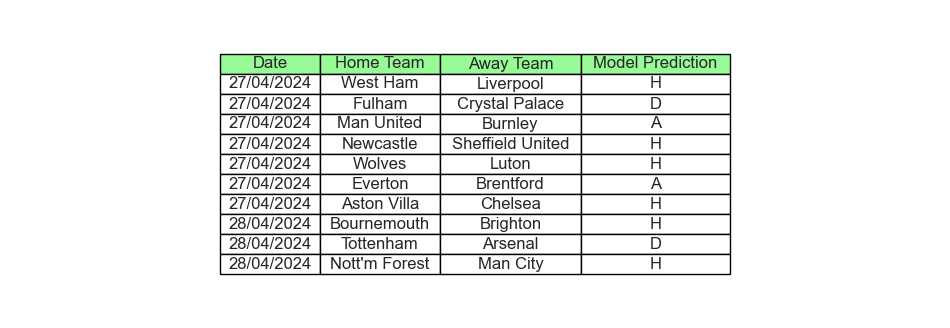

/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_34219/3971809613.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')


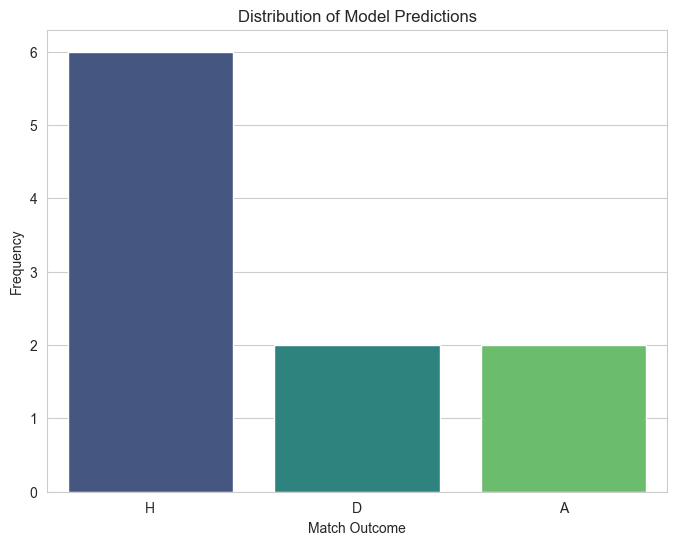

In [113]:
#Table for Model Predictions
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table_data = epl_35[['Date', 'HomeTeam', 'AwayTeam', 'PredictedResult']].values.tolist()
table = ax.table(cellText=table_data, colLabels=['Date', 'Home Team', 'Away Team', 'Model Prediction'], loc='center', cellLoc='center', colColours=["palegreen"]*4)
table.auto_set_column_width(col=list(range(len(epl_35.columns))))
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

#Distribution Bar Chart for Odds Predictions
sns.set_style("whitegrid")

# Count the occurrences of each prediction outcome
outcome_counts = epl_35['PredictedResult'].value_counts()

# Create a bar plot for the prediction outcomes
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')
plt.title('Distribution of Model Predictions')
plt.xlabel('Match Outcome')
plt.ylabel('Frequency')
plt.show()

In [111]:
# Random Predictions
def random_result():
    outcomes = ['H', 'D', 'A']
    return random.choice(outcomes)

epl_35_R = pd.read_csv("epl_mw35.csv")

# Apply random outcome function to each match in the dataframe
epl_35_R['RandomPrediction'] = [random_result() for _ in range(len(epl_35_R))]

# Display the dataframe with the new predictions
print(epl_35_R[['Date', 'HomeTeam', 'AwayTeam', 'RandomPrediction']])


         Date       HomeTeam          AwayTeam RandomPrediction
0  27/04/2024       West Ham         Liverpool                A
1  27/04/2024         Fulham    Crystal Palace                H
2  27/04/2024     Man United           Burnley                A
3  27/04/2024      Newcastle  Sheffield United                H
4  27/04/2024         Wolves             Luton                A
5  27/04/2024        Everton         Brentford                H
6  27/04/2024    Aston Villa           Chelsea                A
7  28/04/2024    Bournemouth          Brighton                H
8  28/04/2024      Tottenham           Arsenal                H
9  28/04/2024  Nott'm Forest          Man City                A


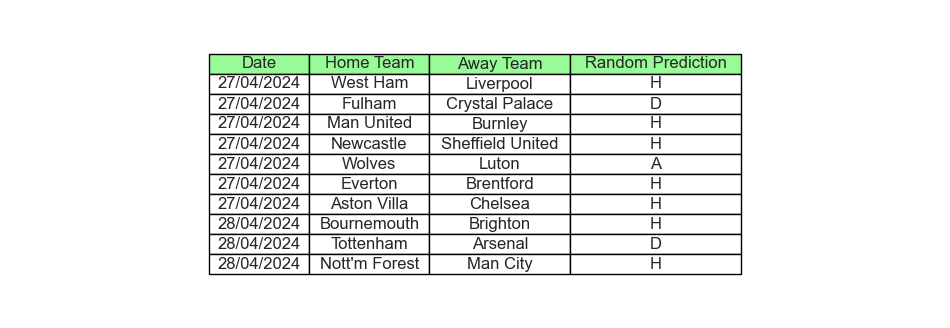

/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_34219/2324945231.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')


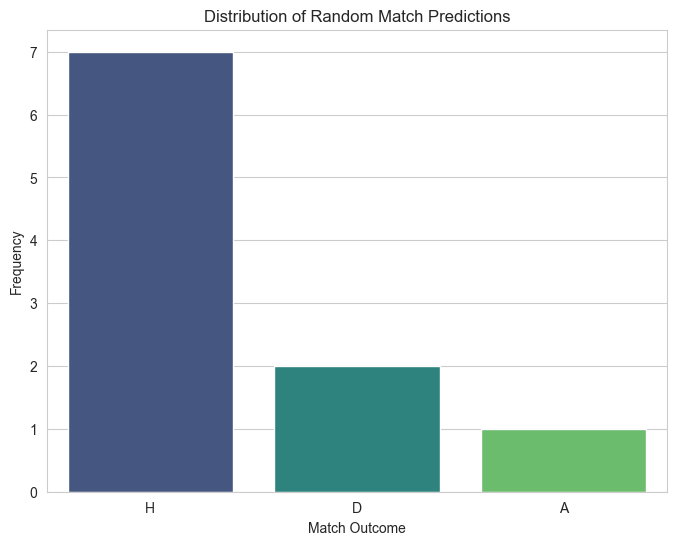

In [42]:
#Table for Random Predictions
fig, ax = plt.subplots(figsize=(12, 4))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Prepare the table data
table_data = epl_35_R[['Date', 'HomeTeam', 'AwayTeam', 'RandomPrediction']].values.tolist()

# Add a table at the bottom of the axes
table = ax.table(cellText=table_data, colLabels=['Date', 'Home Team', 'Away Team', 'Random Prediction'], 
                 loc='center', cellLoc='center', colColours=["palegreen"]*4)

# Auto size the columns
table.auto_set_column_width(col=list(range(len(epl_35_R.columns))))
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

#Distribution Bar Chart for Random Predictions
sns.set_style("whitegrid")

# Count the occurrences of each prediction outcome
outcome_counts = epl_35_R['RandomPrediction'].value_counts()

# Create a bar plot for the prediction outcomes
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')
plt.title('Distribution of Random Match Predictions')
plt.xlabel('Match Outcome')
plt.ylabel('Frequency')
plt.show()


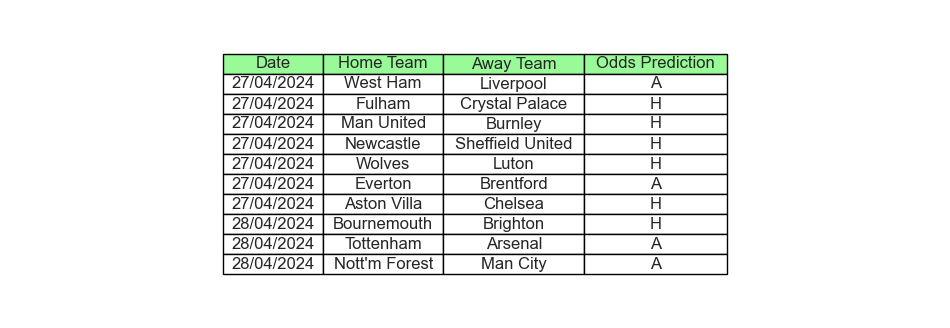

/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_34219/3327232201.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')


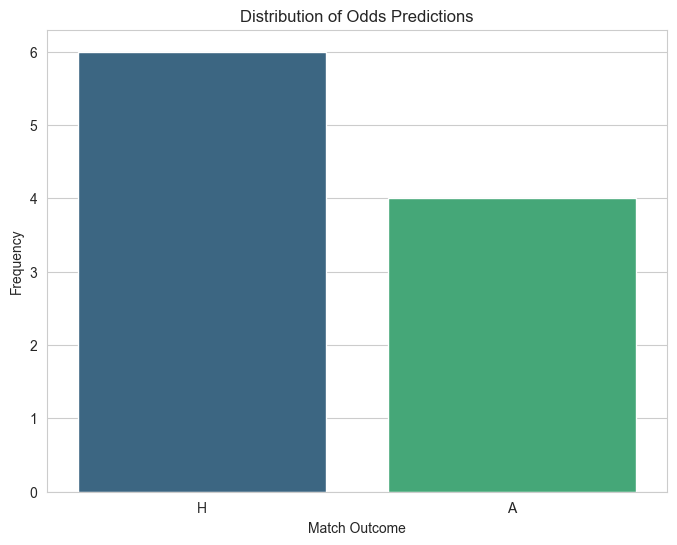

In [44]:
# Odds Predictions
def betting_result(row):
    # The lower the odds, the higher the probability of the event happening
    odds = {
        'H': ((row['B365H'] + row['WHH'])/2),
        'D': ((row['B365D'] + row['WHD'])/2),
        'A': ((row['B365A'] + row['WHA'])/2)
    }
    # The outcome with the lowest odds is the predicted winner
    predicted_outcome = min(odds, key=odds.get)
    return predicted_outcome

epl_35_O = pd.read_csv("epl_mw35.csv")

epl_35_O['OddsPrediction'] = epl_35_O.apply(betting_result, axis=1)

#Table for Odds Predictions
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table_data = epl_35_O[['Date', 'HomeTeam', 'AwayTeam', 'OddsPrediction']].values.tolist()
table = ax.table(cellText=table_data, colLabels=['Date', 'Home Team', 'Away Team', 'Odds Prediction'], loc='center', cellLoc='center', colColours=["palegreen"]*4)
table.auto_set_column_width(col=list(range(len(epl_35_O.columns))))
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

#Distribution Bar Chart for Odds Predictions
sns.set_style("whitegrid")

# Count the occurrences of each prediction outcome
outcome_counts = epl_35_O['OddsPrediction'].value_counts()

# Create a bar plot for the prediction outcomes
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')
plt.title('Distribution of Odds Predictions')
plt.xlabel('Match Outcome')
plt.ylabel('Frequency')
plt.show()